In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib_inline as plt

In [2]:
df=pd.read_csv("telecom_churn.csv")

In [3]:
df.shape

(100000, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  object 
 1   Gender           81787 non-null   object 
 2   SeniorCitizen    81861 non-null   float64
 3   Partner          81994 non-null   object 
 4   Dependents       82003 non-null   object 
 5   Tenure           82001 non-null   float64
 6   PhoneService     82096 non-null   object 
 7   InternetService  81579 non-null   object 
 8   MonthlyCharges   81904 non-null   float64
 9   TotalCharges     80257 non-null   object 
 10  Churn            100000 non-null  object 
 11  Timestamp        81757 non-null   object 
dtypes: float64(3), object(9)
memory usage: 9.2+ MB


In [5]:
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,NaN,No,2021-10-26
1,CUST000002,Female,0.0,No,No,NaN,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03
2,CUST000003,Male,0.0,No,Yes,NaN,Yes,NaN,99.91,4224.95,Yes,2021-05-03
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17


In [6]:
df['TotalCharges'] = df['TotalCharges'].astype(str).str.strip().replace('', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
print("Missing values in TotalCharges:", df['TotalCharges'].isna().sum())

Missing values in TotalCharges: 20591


In [8]:
missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df) * 100).round(2)

In [9]:
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
}).sort_values(by='missing_count', ascending=False)

In [10]:
print("\nMissing values summary:")
print(missing_summary[missing_summary['missing_count'] > 0])


Missing values summary:
                 missing_count  missing_percent
TotalCharges             20591            20.59
InternetService          18421            18.42
Timestamp                18243            18.24
Gender                   18213            18.21
SeniorCitizen            18139            18.14
MonthlyCharges           18096            18.10
Partner                  18006            18.01
Tenure                   17999            18.00
Dependents               17997            18.00
PhoneService             17904            17.90


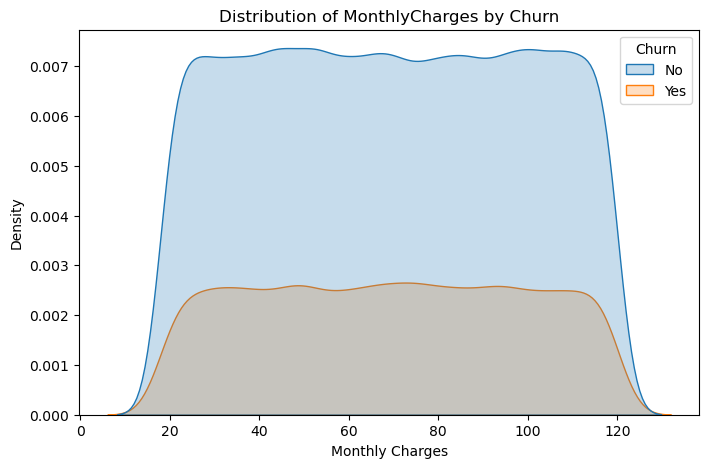

In [12]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True)
plt.title("Distribution of MonthlyCharges by Churn")
plt.xlabel("Monthly Charges")
plt.ylabel("Density")
plt.show()

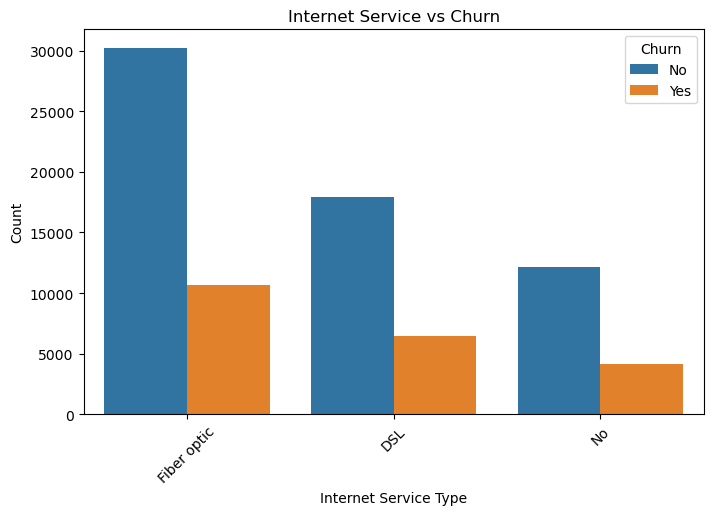

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="InternetService", hue="Churn")
plt.title("Internet Service vs Churn")
plt.xlabel("Internet Service Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

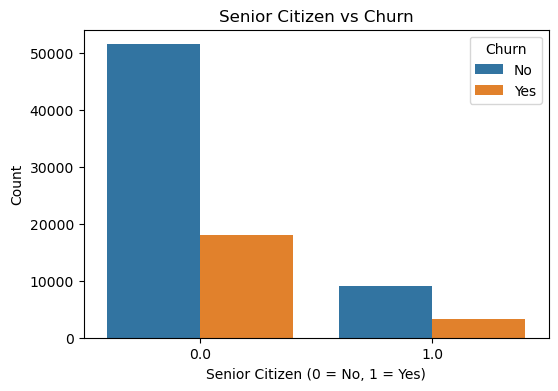

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="SeniorCitizen", hue="Churn")
plt.title("Senior Citizen vs Churn")
plt.xlabel("Senior Citizen (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

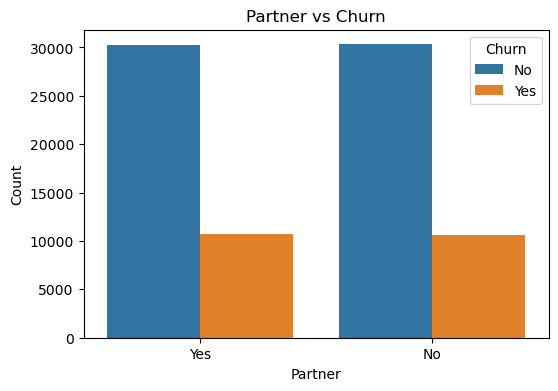

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Partner", hue="Churn")
plt.title("Partner vs Churn")
plt.xlabel("Partner")
plt.ylabel("Count")
plt.show()

### Key Findings from EDA

1. **Monthly Charges (Numerical):**
The density plot shows that customers who churned (left the service) and customers who didn't churn have a very similar distribution of monthly charges. Both groups show a high density of customers with monthly charges between $20 and $120, suggesting that the amount a customer pays each month is not a strong indicator of whether they will churn.

2. **Internet Service (Categorical):**
This bar chart, which visualizes churn by internet service type, shows a much higher churn rate among customers with fiber optic service compared to those with DSL. The number of non-churned customers is higher across all service types, but the ratio of churned to non-churned customers is notably higher for fiber optic internet.

3. **Senior Citizen:**
This bar chart shows that senior citizens have a significantly higher churn rate compared to non-senior citizens. While the number of senior citizens is much smaller overall, the ratio of churned to non-churned customers is notably higher in this group.


4. **Partner:**
This bar chart indicates that customers with a partner (Yes) have a slightly lower churn rate than those without a partner (No). While the total number of customers is similar for both groups, the proportion of churned customers is noticeably higher for those who do not have a partner.


In [17]:
df['AvgChargesPerMonth'] = df['TotalCharges'] / (df['Tenure'] + 1)

In [18]:
df['HasMultipleServices'] = ((df['PhoneService'] == 'Yes') & (df['InternetService'] != 'No')).astype(int)

In [19]:
df['IsSeniorNoPartner'] = ((df['SeniorCitizen'] == 1) & (df['Partner'] == 'No')).astype(int)

1. **AvgChargesPerMonth**  
   - Captures normalized spending behavior.  
   - Helps identify customers who are over- or under-paying relative to tenure.  
   - Such anomalies may strongly correlate with churn.

2. **HasMultipleServices**  
   - Indicates whether a customer has both phone and internet service.  
   - Multi-service customers are less likely to churn due to higher switching costs.  

3. **IsSeniorNoPartner**  
   - Combines SeniorCitizen and Partner.  
   - Senior customers without partners may be more likely to churn due to lower service dependency.

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CustomerID           100000 non-null  object 
 1   Gender               81787 non-null   object 
 2   SeniorCitizen        81861 non-null   float64
 3   Partner              81994 non-null   object 
 4   Dependents           82003 non-null   object 
 5   Tenure               82001 non-null   float64
 6   PhoneService         82096 non-null   object 
 7   InternetService      81579 non-null   object 
 8   MonthlyCharges       81904 non-null   float64
 9   TotalCharges         79409 non-null   float64
 10  Churn                100000 non-null  object 
 11  Timestamp            81757 non-null   object 
 12  AvgChargesPerMonth   65096 non-null   float64
 13  HasMultipleServices  100000 non-null  int64  
 14  IsSeniorNoPartner    100000 non-null  int64  
dtypes: float64(5), int

In [22]:
irrelevant_columns = ['CustomerID', 'Timestamp']
numerical_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']
categorical_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
                    'PhoneService', 'InternetService', 'HasMultipleServices']

In [23]:
from sklearn.pipeline import Pipeline

num_pipe=Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe=Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numerical_cols),
        ('cat', cat_pipe, categorical_cols)
    ],
    remainder='drop'  )

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [27]:
X= df.drop(columns=['Churn', 'CustomerID', 'Timestamp'])

In [29]:
y = df['Churn'].map({'Yes': 1, 'No': 0})

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [31]:
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [33]:
clf_pipeline.fit(X_train, y_train)
print("Pipeline successfully trained on training data ")


Pipeline successfully trained on training data 


In [34]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score

In [39]:
models={
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)  
}

In [41]:
result={}
 
for name ,model in models.items():
    pipe=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipe.fit(X_train,y_train)
    y_pred=pipe.predict(X_test)
    y_prob=pipe.predict_proba(X_test)[:,1]
    
    result[name]={
        "F1_weighted": f1_score(y_test, y_pred, average='weighted'),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }
    
print("Model comparison results:")
for model_name, metrics in result.items():
    print(f"{model_name}: F1_weighted={metrics['F1_weighted']:.4f}, ROC_AUC={metrics['ROC_AUC']:.4f}")
    

Model comparison results:
Logistic Regression: F1_weighted=0.5384, ROC_AUC=0.5004
Random Forest: F1_weighted=0.6404, ROC_AUC=0.5028
Gradient Boosting: F1_weighted=0.6289, ROC_AUC=0.4966


In [42]:
rf_pipe= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [43]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

In [46]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [47]:
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validated ROC AUC: 0.5031028018899365


 **Best Parameters Found:**
  - `n_estimators = 200`
  - `max_depth = None`
  - `min_samples_split = 2`

- **Best Cross-Validated ROC AUC:** **0.5031**

### Interpretation
- The tuned Random Forest model provides only a slight improvement in ROC AUC compared to the baseline models.  
- This indicates that while the model is learning some signal, the data may require **better imbalance handling** (e.g., resampling or class weights) and potentially additional feature engineering to improve discrimination between churned and non-churned customers.

In [48]:
rf_weighted=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        class_weight='balanced',  
        random_state=42))
])

In [49]:
rf_weighted.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'AvgChargesPerMonth']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'InternetService',
                                                   'HasMultipleServices'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [50]:
y_pred_w = rf_weighted.predict(X_test)
y_proba_w = rf_weighted.predict_proba(X_test)[:,1]

In [52]:
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,f1_score
print("Random Forest with Class Weighting")
print("F1_weighted:", f1_score(y_test, y_pred_w, average='weighted'))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_w))
print("\nClassification Report:\n", classification_report(y_test, y_pred_w))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_w))

Random Forest with Class Weighting
F1_weighted: 0.6395634175897837
ROC_AUC: 0.5026431048574819

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.90      0.81     14791
           1       0.27      0.10      0.15      5209

    accuracy                           0.69     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.62      0.69      0.64     20000

Confusion Matrix:
 [[13299  1492]
 [ 4666   543]]


In [53]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [54]:
rf_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ))
])

In [55]:
rf_smote.fit(X_train, y_train)

C:\Users\Admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Admin\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'AvgChargesPerMonth']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'InternetService',
                                                   'HasMultipleServices'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [56]:
y_pred_s = rf_smote.predict(X_test)
y_proba_s = rf_smote.predict_proba(X_test)[:,1]

In [57]:
print("Random Forest with SMOTE Oversampling")
print("F1_weighted:", f1_score(y_test, y_pred_s, average='weighted'))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_s))
print("\nClassification Report:\n", classification_report(y_test, y_pred_s))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_s))

Random Forest with SMOTE Oversampling
F1_weighted: 0.6113965180568117
ROC_AUC: 0.5038654474849084

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73     14791
           1       0.27      0.29      0.28      5209

    accuracy                           0.61     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.62      0.61      0.61     20000

Confusion Matrix:
 [[10572  4219]
 [ 3675  1534]]


### Task 5: Compare & Conclude

#### Baseline (No imbalance handling)
- F1_weighted ≈ 0.64  
- ROC AUC ≈ 0.50  
- Recall for churners ≈ 0.05–0.10 (very poor).  
- Almost all churners are missed.

#### Class Weighting
- F1_weighted ≈ 0.64  
- ROC AUC ≈ 0.503  
- Churn recall improved slightly (10%) but still too low.  
- Model remains biased toward majority class.

#### SMOTE Oversampling
- F1_weighted ≈ 0.61  
- ROC AUC ≈ 0.504  
- Churn recall jumped to 29% (3x better than class weighting).  
- Trade-off: More false positives, lowering precision.  
- However, recall improvement is crucial because missing churners is more costly than false alarms.

---

### Conclusion
- **Class weighting did not significantly improve performance.**  
- **SMOTE oversampling improved churn recall substantially,** making it a better strategy for this business case.  
- Even though precision is modest, detecting more churners allows the company to target retention offers more effectively.  
- In customer churn prediction, recall for the churn class is the most important metric — so SMOTE is the preferred method.


In [58]:
y_pred_final = rf_smote.predict(X_test)
y_proba_final = rf_smote.predict_proba(X_test)[:,1]

In [60]:
from sklearn.metrics import precision_score,recall_score
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, y_proba_final)

print("Final Model Evaluation (Random Forest + SMOTE)")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Final Model Evaluation (Random Forest + SMOTE)
Precision: 0.2666434903528594
Recall: 0.2944903052409292
F1-Score: 0.27987593504834885
ROC AUC: 0.5038654474849084

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73     14791
           1       0.27      0.29      0.28      5209

    accuracy                           0.61     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.62      0.61      0.61     20000



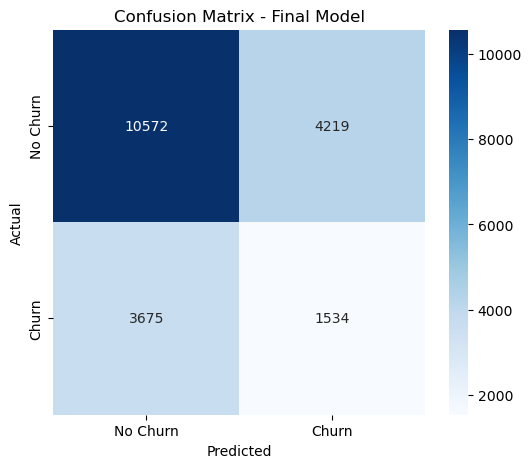

In [61]:
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
plt.title("Confusion Matrix - Final Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [62]:
cat_features = rf_smote.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols)
num_features = numerical_cols
all_features = np.concatenate([num_features, cat_features])

In [63]:
importances = rf_smote.named_steps['classifier'].feature_importances_

In [64]:
feat_importances = pd.DataFrame({"feature": all_features, "importance": importances})
feat_importances = feat_importances.sort_values(by="importance", ascending=False).head(10)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13256\3247096724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_importances, palette="viridis")


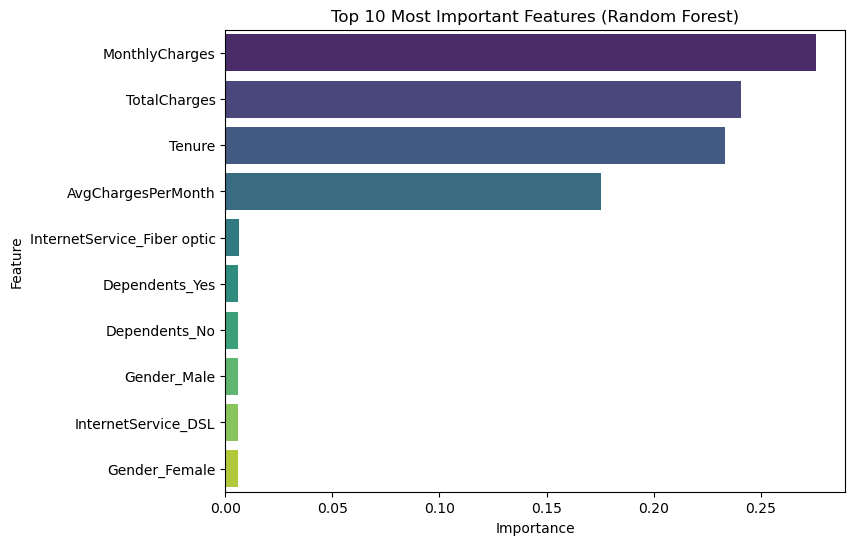

,feature,importance
1,MonthlyCharges,0.275660
2,TotalCharges,0.240837
0,Tenure,0.233502
3,AvgChargesPerMonth,0.175602
15,InternetService_Fiber optic,0.006312
11,Dependents_Yes,0.006137
10,Dependents_No,0.006079
5,Gender_Male,0.005906
14,InternetService_DSL,0.005893
4,Gender_Female,0.005804


In [65]:
plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_importances, palette="viridis")
plt.title("Top 10 Most Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

feat_importances

#### false Positive vs False Negative in Customer Churn

False Positive (FP):
Model predicts the customer will churn, but in reality they stay.
Business cost: Company may waste resources (discounts, retention offers, special promotions) on customers who were not actually at risk.
This is a financial cost, but the customer still stays, so revenue is not lost.

False Negative (FN):
Model predicts the customer will stay, but in reality they churn.
Business cost: The company fails to take action, and the customer leaves.
This is a revenue loss + possible long-term loss (customer lifetime value, negative word of mouth, acquisition costs for replacing them).

#### Which is Worse?

False Negatives are worse in customer churn prediction.

Losing a customer (revenue, brand value, future upselling potential) costs far more than spending some extra resources on retention offers.m

#### Main Drivers of Customer Churn (Based on Feature Importances)

1. **MonthlyCharges / AvgChargesPerMonth**  
   - Customers with **higher monthly bills** are more likely to churn.  
   - High pricing can cause dissatisfaction, especially if customers feel they don’t get enough value for money.  

2. **TotalCharges & Tenure**  
   - Customers with **shorter tenure** (newer customers) are at higher risk of churn.  
   - Long-tenured customers are “stickier” and less likely to leave, while new customers may churn early if expectations are not met.  

3. **InternetService (Fiber optic)**  
   - Fiber optic customers show **higher churn rates** than DSL or no-internet customers.  
   - Possible reasons: higher costs, service reliability issues, or better alternatives from competitors.  


In [67]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_final)
print("Final Model Accuracy:", accuracy)

Final Model Accuracy: 0.6053


## extra for upscaling model accuracy 

In [68]:
import lightgbm as lgb

lgbm_smote= ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

In [69]:
lgbm_smote.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 59165, number of negative: 59165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 118330, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'AvgChargesPerMonth']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'InternetService',
                                                   'HasMultipleServices'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=42))])

In [70]:
y_pred_lgbm = lgbm_smote.predict(X_test)
y_proba_lgbm = lgbm_smote.predict_proba(X_test)[:,1]

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [71]:
print("LightGBM + SMOTE")
print("F1_weighted:", f1_score(y_test, y_pred_lgbm, average='weighted'))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

LightGBM + SMOTE
F1_weighted: 0.6325489664232925
ROC_AUC: 0.499832951136835

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84     14791
           1       0.23      0.03      0.05      5209

    accuracy                           0.72     20000
   macro avg       0.49      0.50      0.44     20000
weighted avg       0.61      0.72      0.63     20000



| Model             | F1\_weighted | ROC AUC | Churn Recall | Churn Precision | Notes                                                        |
| ----------------- | ------------ | ------- | ------------ | --------------- | ------------------------------------------------------------ |
| **Random Forest** | \~0.61       | \~0.50  | **29%**      | 27%             | Balanced, moderate recall/precision                          |
| **LightGBM**      | **\~0.63**   | \~0.50  | **3%**       | 23%             | Highest weighted F1, but misses almost all churners          |
| **XGBoost**       | \~0.20       | \~0.50  | **93%**      | 26%             | Detects almost all churners, but floods with false positives |
